In [1]:
import sys
sys.path.insert(0,"../Classes")
from DataClass import DataLoader

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def get_hist(img,region = None):
    shapes = img.shape
    hist = np.zeros((256,3))
    for a in range(3):
        if region is None:
            vs,ids,cnts = np.unique(img[:,:,a],return_inverse=True,return_counts=True)
        else:
            vs,ids,cnts = np.unique(img[:,:,a][region],return_inverse=True,return_counts=True)
        notin = np.array([a for a in range(256) if a not in vs])
        for b in notin:
            cnts = np.insert(cnts,b,0)
        hist[:,a]=cnts
    return hist

def sing_cum_hist(img):
    c_hist = get_hist(img)
    cum_hist = np.cumsum(c_hist,axis=0)
    cum_hist = cum_hist/cum_hist[-1]
    return cum_hist

def get_cum_hist(dataloader,check_region=False):
    hist = np.zeros((256,3))
    the_range = len(dataloader.classfiles)
    for a in tqdm(range(the_range)):
        img = dataloader.get_data("flat",[a])[0]
        if not check_region:
            c_hist = get_hist(img)
        else:
            reg = dataloader.get_data("region",[a])[0][:,:,0].astype(bool)
            c_hist = get_hist(img,region = reg)
        hist += c_hist
    cum_hist = np.cumsum(hist,axis=0)
    cum_hist = cum_hist/cum_hist[-1]
    return cum_hist

In [3]:
#Deals with missing values from 0 to 255
def uq_w_ind(img):
    vs,inds = np.unique(img,return_inverse=True)
    miss = [a for a in range(256) if a not in vs]
    for a in miss:
        vs = np.insert(vs,a,a)
        inds[inds>a]=inds[inds>a]+1
    return vs,inds

def get_interps(h1,h2):
    i1 = np.interp(h2[:,0],h1[:,0],[a for a in range(256)])
    i2 = np.interp(h2[:,1],h1[:,1],[a for a in range(256)])
    i3 = np.interp(h2[:,2],h1[:,2],[a for a in range(256)])
    return [i1,i2,i3]
def run_interp(img,interps):
    img_out = np.zeros((img.shape))
    for a in range(3):
        vals,bin_idx = uq_w_ind(img[:,:,a])
        img_out[:,:,a] = interps[a][bin_idx].reshape((img.shape[0:2]))
    return img_out

In [4]:
def interp_hist(dataloader,interps,check_region=False):
    hist = np.zeros((256,3))
    the_range = len(dataloader.classfiles)
    for a in tqdm(range(the_range)):
        img = dataloader.get_data("flat",[a])[0]
        img2 = run_interp(img,interps).astype(np.uint8)
        if not check_region:
            c_hist = get_hist(img2)
        else:
            reg = dataloader.get_data("region",[a])[0][:,:,0].astype(bool)
            c_hist = get_hist(img2,region = reg)
        hist += c_hist
    cum_hist = np.cumsum(hist,axis=0)
    cum_hist = cum_hist/cum_hist[-1]
    return cum_hist

In [5]:
def plot_hists(hist):
    plt.plot(hist[:,0],c='red')
    plt.plot(hist[:,1],c='green')
    plt.plot(hist[:,2],c='blue')
    plt.show()

In [6]:
dl1 = DataLoader()
dl2 = DataLoader()

dl1.load_std_folder("../../../Data/STD_Folder")
dl2.load_std_folder("../../../Data/DataSet2/converted",get_valid_region=True)

dl1.parse_biclass()

In [7]:
hists_dl1 = get_cum_hist(dl1)
hists_dl2 = get_cum_hist(dl2,check_region=True)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

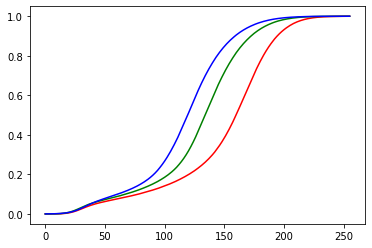

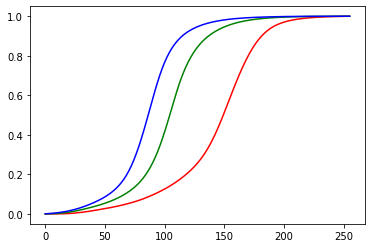

In [8]:
plot_hists(hists_dl1)
plot_hists(hists_dl2)

In [9]:
interps = get_interps(hists_dl1,hists_dl2)

  0%|          | 0/36 [00:00<?, ?it/s]

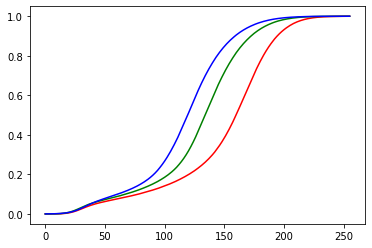

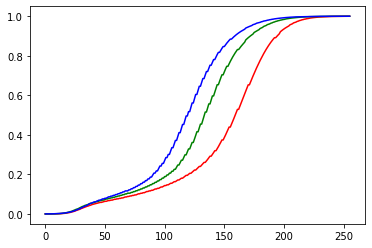

In [10]:
hists_interped = interp_hist(dl2,interps,check_region=True)
plot_hists(hists_dl1)
plot_hists(hists_interped)

In [11]:
np.save("interps_newdata",np.array(interps))